In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/gdrive/')

import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

!pip install pandasql
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as ans
import pandasql as ps
from sqlite3 import connect

Mounted at /content/gdrive/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=1aa6c216178710d1bcb1a30ebacb9a2f0aa556a41ab81afe3e1c1f9608f4dc5c
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
filePath = "/content/gdrive/MyDrive/Research Paper Cohort 2/Compustat Folder/"

#Import compustat CSV
file = filePath + "CompustatQuarterlyCleaned.csv"
df = pd.read_csv(file)

print(df)

          tic    datadate  fyearq  fqtr indfmt datafmt  cogsq   sic  saleq  \
0      ADCT.1  2005-01-31    2005   1.0   INDL     STD  145.0  3661  241.0   
1      ADCT.1  2005-04-30    2005   2.0   INDL     STD  157.1  3661  288.8   
2      ADCT.1  2005-07-31    2005   3.0   INDL     STD  183.8  3661  305.6   
3      ADCT.1  2005-10-31    2005   4.0   INDL     STD  150.8  3661  294.0   
4      ADCT.1  2006-01-31    2006   1.0   INDL     STD  170.1  3661  272.8   
...       ...         ...     ...   ...    ...     ...    ...   ...    ...   
63426    ALLE  2014-12-31    2014   4.0   INDL     STD  328.7  3420  573.5   
63427    ALLE  2015-03-31    2015   1.0   INDL     STD  255.3  3420  458.7   
63428    ALLE  2015-06-30    2015   2.0   INDL     STD  281.5  3420  519.5   
63429    ALLE  2015-09-30    2015   3.0   INDL     STD  291.7  3420  544.5   
63430    ALLE  2015-12-31    2015   4.0   INDL     STD  299.5  3420  545.4   

         cshoq  prccq   ceqq  xsgaq  time  treatment  CogsRevRa

In [ ]:
file = filePath + "CompustatAnnual1950to2022.csv"
columnsToUse = ['tic', 'datadate', 'fyear', 'indfmt', 'datafmt', 'cogs', 'sic', 'sale', 'csho', 'prcc_f', 'ceq']
compustat1950To2022 = pd.read_csv(file, usecols = columnsToUse)[columnsToUse]

compustat2005To2015 = compustat1950To2022[(compustat1950To2022['fyear'] >= 2005) & (compustat1950To2022['fyear'] <= 2015)]
compustat2005To2015 = compustat2005To2015[
    ((compustat2005To2015['sic'] >= 2000) & (compustat2005To2015['sic'] <= 2799)) |
    ((compustat2005To2015['sic'] >= 3011) & (compustat2005To2015['sic'] <= 3079)) |
    ((compustat2005To2015['sic'] >= 3100) & (compustat2005To2015['sic'] <= 3499)) |
    ((compustat2005To2015['sic'] >= 3600) & (compustat2005To2015['sic'] <= 3820)) |
    ((compustat2005To2015['sic'] >= 3910) & (compustat2005To2015['sic'] <= 3999)) |
    ((compustat2005To2015['sic'] >= 5200) & (compustat2005To2015['sic'] <= 5999))
]

In [ ]:
##Winsorizing and cleaning
lower_threshold = compustat2005To2015['sale'].quantile(0.01)
upper_threshold = compustat2005To2015['sale'].quantile(0.99)
compustat2005To2015 = compustat2005To2015[(compustat2005To2015['sale'] >= lower_threshold) & (compustat2005To2015['sale'] <= upper_threshold)]

compustat2005To2015 = compustat2005To2015.dropna()
compustat2005To2015 = compustat2005To2015[compustat2005To2015['cogs'] != 0]
dfA = compustat2005To2015
print(dfA)

           tic  datadate   fyear indfmt datafmt      cogs     sic      sale  \
266     ADCT.1  20051031  2005.0   INDL     STD   681.100  3661.0  1169.200   
267     ADCT.1  20061031  2006.0   INDL     STD   801.100  3661.0  1281.900   
268     ADCT.1  20071031  2007.0   INDL     STD   827.500  3661.0  1322.200   
269     ADCT.1  20081031  2008.0   INDL     STD   870.700  3661.0  1456.400   
270     ADCT.1  20090930  2009.0   INDL     STD   600.500  3661.0   996.700   
...        ...       ...     ...    ...     ...       ...     ...       ...   
590817    LS.1  20110331  2010.0   INDL     STD   220.853  3317.0   240.305   
591051    ALLE  20131231  2013.0   INDL     STD  1206.000  3420.0  2093.500   
591052    ALLE  20141231  2014.0   INDL     STD  1185.500  3420.0  2118.300   
591053    ALLE  20151231  2015.0   INDL     STD  1132.900  3420.0  2068.100   
591088    NOMD  20151231  2015.0   INDL     STD   656.100  2030.0   971.013   

           csho  prcc_f       ceq  
266     116.500

In [ ]:
dfA['datadate'] = pd.to_datetime(dfA['datadate'])

# Convert 'sale' and 'cogs' to numeric if they are not already
dfA['sale'] = pd.to_numeric(dfA['sale'], errors='coerce')  # coerce errors to NaN if any
dfA['cogs'] = pd.to_numeric(dfA['cogs'], errors='coerce')

# Create the 'time' and 'treatment' columns
dfA['time'] = (dfA['fyear'] >= 2010).astype(int)
dfA['treatment'] = (dfA['sale'] >= 100).astype(int)

# Create the 'CogsRevRatio' column
dfA['CogsRevRatio'] = dfA['cogs'] / dfA['sale'] #In percent
# Create the 'timeXtreatment' column
dfA['timeXtreatment'] = dfA['time'] * dfA['treatment']
# Create the 'marketValue' column (assuming you meant to multiply 'csho' and 'prcc_f')
dfA['marketValue'] = dfA['csho'] * dfA['prcc_f']
# Create the 'bookToMarket' column
dfA['bookToMarket'] = dfA['ceq'] / dfA['marketValue']

# Print the updated DataFrame
print(dfA)

dfACopy = dfA

           tic                      datadate   fyear indfmt datafmt      cogs  \
266     ADCT.1 1970-01-01 00:00:00.020051031  2005.0   INDL     STD   681.100   
267     ADCT.1 1970-01-01 00:00:00.020061031  2006.0   INDL     STD   801.100   
268     ADCT.1 1970-01-01 00:00:00.020071031  2007.0   INDL     STD   827.500   
269     ADCT.1 1970-01-01 00:00:00.020081031  2008.0   INDL     STD   870.700   
270     ADCT.1 1970-01-01 00:00:00.020090930  2009.0   INDL     STD   600.500   
...        ...                           ...     ...    ...     ...       ...   
590817    LS.1 1970-01-01 00:00:00.020110331  2010.0   INDL     STD   220.853   
591051    ALLE 1970-01-01 00:00:00.020131231  2013.0   INDL     STD  1206.000   
591052    ALLE 1970-01-01 00:00:00.020141231  2014.0   INDL     STD  1185.500   
591053    ALLE 1970-01-01 00:00:00.020151231  2015.0   INDL     STD  1132.900   
591088    NOMD 1970-01-01 00:00:00.020151231  2015.0   INDL     STD   656.100   

           sic      sale   

In [ ]:
dfA = dfA[(dfA['sale'] >= 75) & (dfA['sale'] <= 125)]

In [ ]:
data = [
    "ACU", "APNI", "CMQ", "HAIPF", "AMK.2", "ANEN", "ATRO", "DFZ", "LEXPQ", "WEDC", "CAMP", "CVCO", "ABAT", "CBYDF", "CRWS", "VIEWF", "NSYS", "COBR", "EML", "ENERQ", "EXAR", "FSCR", "BDL", "FRD", "GLDC", "GHM", "PXFG", "HWG", "AMOT", "IEC", "INVX", "NGAC.1", "CYBI", "MXWL", "MCRAA", "MRFD", "NATH", "PRLX.", "RADN", "SIF", "SPEC.2", "SGC", "SUPX", "SNKI", "SYNL", "SSY", "TOD", "VALU", "VIDE", "CUSI", "SPB", "ELA", "SIGM", "3CHBD", "MAG.3", "5872B", "XETA", "DRJ", "ARCW", "MHGU", "HRLSQ", "FKWL", "RBI", "HEARQ", "JRJRQ", "MGHRF", "LWAY", "AMBA", "IRIG", "NEEB", "MONT", "3NQDRF", "DRTT", "USHS", "AMZKF.1", "AVPFF", "AERT", "LMPLF", "BMPAF", "FRSH.2", "GLDLF.", "HMFAF", "HIS.", "SRXHF", "TIMNF", "VHL.Z", "CRFT", "FRPT", "DMK.", "UNIR", "QKLS", "MODTQ", "JOEZ", "GND.", "TBACQ", "AMSC", "VTSS", "GWSV", "KOPN", "LSCG", "CRCV", "HAMPQ", "FCEL", "CVUA", "RUM.3", "ZOLT", "MRVC", "SHFL", "TUTR", "ULBI", "NEMFF", "CHMP", "WFIFF", "SNT", "THRM", "CYDS", "PSTA", "GLLC", "MED", "TFCO", "MCZAF", "WRLS.1", "ARTX", "MPAA", "BOOT.1", "AHMS", "TBUSQ", "TSEM", "ANAD", "ESST", "ZCOM", "RICK", "CFCI", "WSTL", "IDWK", "SLNK", "BOBS", "ORCT", "BBQ", "SNAK", "DEL", "HLIO", "EFJI", "BFLY.1", "TFRFF", "STRZ", "PSEM", "ICPBF", "SHOEQ", "CIX", "OSPN", "NLVGF", "PPAFQ", "AJXGF", "MTYFF", "GBO.H", "PPEHF", "SPS.", "WPRT", "OME", "CRTP", "GAI", "JADE", "AXTI", "LMIA", "ADGF", "TERN.1", "CVVT", "TUN.Z", "PLXT", "SIDGQ", "SWIR", "ABLE", "ADFJF", "IFSG", "ROFO", "PCTI", "PLUG", "AXST", "GKNT", "CNGL.2", "PSITY", "PXLW", "TUNE", "OCNW", "STLW", "MIMO", "CRNT", "OIIM", "CYY.Z", "OPLK", "ESLRQ", "ZHNE", "AFOP", "RLPHQ", "HMDPF", "MPX", "TSTC", "AXON", "PGSW", "GCFB", "CREG", "COSIQ", "CBAT", "HUX.Z", "CAAS", "NEWN", "RUTFF", "TRLG", "BZRD", "MSPD", "REDEQ", "XPER", "PPLI", "CMHXF", "PRPX", "GSIT", "NETL.1", "LDIS", "VLTR", "IKAN", "MPWR", "BDAY", "3NHRX", "ORSX", "OPMMF", "SOM.Z", "AATI", "CNTFY", "TISUQ", "XSC.UN", "CMPR", "ATNY", "OFLX", "SIMO", "KONA", "SSI.1", "BDBD", "CROX", "DOVR", "WATG", "VNWTF", "ACTS", "MRTKF", "EVK", "CSR.", "LQDT", "GRRF", "BIDZ", "ADNC", "LBN.U", "VALV", "TXIC", "DPI.UN", "OFB.U", "IPGP", "NLST", "KNDI", "TSL", "CLNE", "MLNX", "CPSL.", "JASO", "UECN", "ITP", "SHOR", "DRWIQ", "STAR.2", "ATV", "LDKYQ", "RUGGF", "SPRD", "FOOD", "SPI", "KIDSQ", "CRGIY", "FUQI", "AMCO", "OESX", "FOHL", "BCDS.1", "RGSEQ", "KALY", "CJJD", "VITC", "HPJ", "STRI", "AONEQ", "SAUC", "HASC", "ZSTN", "MERU", "KGJI", "PPSI", "DQ", "PRMW.1", "MXL", "NVFY", "BORNY", "TSLA", "IPHI", "INVN", "OSN", "CCSC", "ABCXF", "CUBG", "UMAM", "XNY.1", "DANG", "PSMI", "ZAHLY", "ANNC", "SQNS", "TEA", "VCRA", "CHUY", "PRSS", "FRG", "AIOCF", "BNNY", "DLGS", "COA", "LS.1", "AIN.U", "CLAR", "NSSC", "LBMH", "BREW", "RBCN", "WSGI", "ARUZQ", "DSWL", "ESCA", "PGL.Z", "EXEX", "UTSI", "PPIH", "BOYD", "COHM", "PNS", "BLDP", "EMKR", "GRLL", "FELI", "AIRI", "SIMC", "CRVP", "CACS", "HITT", "SWSSF", "CSNH", "TPOSQ", "PLAG", "BRID", "CTLM", "RDMX.1", "SPWR", "HRBN", "MIGL", "SCOP", "ASCLF", "CHGS", "JST", "HEVVQ", "DEER", "SORL", "PME", "MASC", "ALDA.1", "ALLI", "OCC", "ITLN", "CASA.1", "ZILG", "ACAZF", "HEAT", "MGAM.1", "FPWBQ", "MSD.1", "PRXM", "TLFA", "NICH", "CRGI.", "PISEF", "TRIDQ", "WING", "MCEM", "OPMR", "WCRS", "RVLT", "3FATS", "AUDC", "GPIC", "DITC", "CPGI", "CMFO", "SFUN.2", "ENTR.1", "MSN", "CDVIF", "SPIR.1", "ADY", "IPT", "3ECNG", "ERILF", "POOSF", "CNRD", "SIPX", "MFW", "OLED", "PBIX", "CATS.1", "HQCL", "USAP", "AAOI", "CHRK", "ARKR", "PAHAF", "ZAGG", "AEHL", "DYNGF.", "SFLY", "SGMA"
]

tics = pd.DataFrame({'tic': data})

path = filePath + "cali.txt"

with open(path, 'r') as file:
    # Read lines from the file and convert to integers
    data2 = [int(line.strip()) for line in file]

Cali = pd.DataFrame({'cali': data2})

print(Cali)

     cali
0       1
1       0
2       1
3       0
4       1
..    ...
418     1
419     0
420     0
421     1
422     1

[423 rows x 1 columns]


In [ ]:
dfOperations = pd.concat([tics, Cali], axis=1)
print(dfOperations)

        tic  cali
0       ACU     1
1      APNI     0
2       CMQ     1
3     HAIPF     0
4     AMK.2     1
..      ...   ...
418    ZAGG     1
419    AEHL     0
420  DYNGF.     0
421    SFLY     1
422    SGMA     1

[423 rows x 2 columns]


In [ ]:
###SETTING UP ALL NECESSARY DATAFRAMES

###Currently:       df, dfA, dfoperations
### Want to add: dfACali, dfAPlacebo
dfACali = dfA[(dfA['tic'].isin(dfOperations[dfOperations['cali'] == 1]['tic'])) & (dfA['tic'].isin(dfOperations['tic']))]
dfAPlacebo = dfA[(dfA['tic'].isin(dfOperations[dfOperations['cali'] == 0]['tic'])) & (dfA['tic'].isin(dfOperations['tic']))]

print(dfACali)
print(dfAPlacebo)

          tic                      datadate   fyear indfmt datafmt     cogs  \
2268      ACU 1970-01-01 00:00:00.020121231  2012.0   INDL     STD   53.533   
2269      ACU 1970-01-01 00:00:00.020131231  2013.0   INDL     STD   56.548   
2270      ACU 1970-01-01 00:00:00.020141231  2014.0   INDL     STD   67.137   
2271      ACU 1970-01-01 00:00:00.020151231  2015.0   INDL     STD   67.799   
9370      CMQ 1970-01-01 00:00:00.020061231  2006.0   INDL     STD   94.934   
...       ...                           ...     ...    ...     ...      ...   
582610   VCRA 1970-01-01 00:00:00.020151231  2015.0   INDL     STD   36.711   
583107   PRSS 1970-01-01 00:00:00.020151231  2015.0   INDL     STD   56.818   
584309  AIOCF 1970-01-01 00:00:00.020121231  2012.0   INDL     STD   50.535   
587127   DLGS 1970-01-01 00:00:00.020061231  2006.0   INDL     STD   69.432   
590816   LS.1 1970-01-01 00:00:00.020100331  2009.0   INDL     STD  114.407   

           sic     sale    csho  prcc_f      ceq  t

In [ ]:
dfACaliMerged = dfACali.merge(df, left_on=['tic', 'fyear'], right_on=['tic', 'fyearq'], how='inner')
dfAPlaceboMerged = dfAPlacebo.merge(df, left_on=['tic', 'fyear'], right_on=['tic', 'fyearq'], how='inner')

In [ ]:
dfACaliPre2010 = dfACali[dfACali['fyear'] < 2010]
dfACaliPost2010 = dfACali[dfACali['fyear'] >= 2010]
dfAPlaceboPre2010 = dfAPlacebo[dfAPlacebo['fyear'] < 2010]
dfAPlaceboPost2010 = dfAPlacebo[dfAPlacebo['fyear'] >= 2010]
print(dfAPlaceboPre2010.tic.nunique())
print(dfAPlaceboPost2010.tic.nunique())

182
106


In [ ]:
print(dfACaliMerged.columns)

Index(['tic', 'datadate_x', 'fyear', 'indfmt_x', 'datafmt_x', 'cogs', 'sic_x',
       'sale', 'csho', 'prcc_f', 'ceq', 'time_x', 'treatment_x',
       'CogsRevRatio_x', 'timeXtreatment_x', 'marketValue_x', 'bookToMarket_x',
       'datadate_y', 'fyearq', 'fqtr', 'indfmt_y', 'datafmt_y', 'cogsq',
       'sic_y', 'saleq', 'cshoq', 'prccq', 'ceqq', 'xsgaq', 'time_y',
       'treatment_y', 'CogsRevRatio_y', 'timeXtreatment_y', 'marketValue_y',
       'bookToMarket_y'],
      dtype='object')


In [ ]:
### Table 1 CALI
print("Number of firms: " + str(dfAPlaceboPre2010['tic'].nunique()))

print("Revenue Min: " + str(dfAPlaceboPre2010['sale'].min()))
print("Revenue 10th Percentile: " + str(dfAPlaceboPre2010['sale'].quantile(0.1)))
print("Revenue 25th Percentile: " + str(dfAPlaceboPre2010['sale'].quantile(0.25)))
print("Revenue 50th Percentile: " + str(dfAPlaceboPre2010['sale'].quantile(0.50)))
print("Revenue 75th Percentile: " + str(dfAPlaceboPre2010['sale'].quantile(0.75)))
print("Revenue 90th Percentile: " + str(dfAPlaceboPre2010['sale'].quantile(0.90)))
print("Revenue Max: " + str(dfAPlaceboPre2010['sale'].max()))

print("COGS Min  : " + str(dfAPlaceboPre2010['cogs'].min()))
print("COGS 10th Percentile  : " + str(dfAPlaceboPre2010['cogs'].quantile(0.1)))
print("COGS 25th Percentile  : " + str(dfAPlaceboPre2010['cogs'].quantile(0.25)))
print("COGS 50th Percentile  : " + str(dfAPlaceboPre2010['cogs'].quantile(0.50)))
print("COGS 75th Percentile  : " + str(dfAPlaceboPre2010['cogs'].quantile(0.75)))
print("COGS 90th Percentile  : " + str(dfAPlaceboPre2010['cogs'].quantile(0.90)))
print("COGS Max  : " + str(dfAPlaceboPre2010['cogs'].max()))

print("Cogs/rev Ratio Min  : " + str(dfAPlaceboPre2010['CogsRevRatio'].min()))
print("Cogs/rev Ratio 10th Percentile  : " + str(dfAPlaceboPre2010['CogsRevRatio'].quantile(0.1)))
print("Cogs/rev Ratio 25th Percentile  : " + str(dfAPlaceboPre2010['CogsRevRatio'].quantile(0.25)))
print("Cogs/rev Ratio 50th Percentile  : " + str(dfAPlaceboPre2010['CogsRevRatio'].quantile(0.50)))
print("Cogs/rev Ratio 75th Percentile  : " + str(dfAPlaceboPre2010['CogsRevRatio'].quantile(0.75)))
print("Cogs/rev Ratio 90th Percentile  : " + str(dfAPlaceboPre2010['CogsRevRatio'].quantile(0.90)))
print("Cogs/rev Ratio Max  : " + str(dfAPlaceboPre2010['CogsRevRatio'].max()))

print("Market cap Min  : " + str(dfAPlaceboPre2010['marketValue'].min()))
print("Market cap 10th Percentile  : " + str(dfAPlaceboPre2010['marketValue'].quantile(0.1)))
print("Market cap 25th Percentile  : " + str(dfAPlaceboPre2010['marketValue'].quantile(0.25)))
print("Market cap 50th Percentile  : " + str(dfAPlaceboPre2010['marketValue'].quantile(0.50)))
print("Market cap 75th Percentile  : " + str(dfAPlaceboPre2010['marketValue'].quantile(0.75)))
print("Market cap 90th Percentile  : " + str(dfAPlaceboPre2010['marketValue'].quantile(0.90)))
print("Market cap Max  : " + str(dfAPlaceboPre2010['marketValue'].max()))

print("B/M  Min  : " + str(dfAPlaceboPre2010['bookToMarket'].min()))
print("B/M  10th Percentile  : " + str(dfAPlaceboPre2010['bookToMarket'].quantile(0.1)))
print("B/M  25th Percentile  : " + str(dfAPlaceboPre2010['bookToMarket'].quantile(0.25)))
print("B/M  50th Percentile  : " + str(dfAPlaceboPre2010['bookToMarket'].quantile(0.50)))
print("B/M  75th Percentile  : " + str(dfAPlaceboPre2010['bookToMarket'].quantile(0.75)))
print("B/M  90th Percentile  : " + str(dfAPlaceboPre2010['bookToMarket'].quantile(0.90)))
print("B/M  Max  : " + str(dfAPlaceboPre2010['bookToMarket'].max()))

Number of firms: 182
Revenue Min: 75.004
Revenue 10th Percentile: 77.7595
Revenue 25th Percentile: 83.02725
Revenue 50th Percentile: 95.17
Revenue 75th Percentile: 108.8435
Revenue 90th Percentile: 118.914
Revenue Max: 124.907
COGS Min  : 2.223
COGS 10th Percentile  : 38.1425
COGS 25th Percentile  : 50.244
COGS 50th Percentile  : 66.527
COGS 75th Percentile  : 79.49675
COGS 90th Percentile  : 91.6795
COGS Max  : 144.341
Cogs/rev Ratio Min  : 0.018233716380816455
Cogs/rev Ratio 10th Percentile  : 0.4230930110309697
Cogs/rev Ratio 25th Percentile  : 0.5658971471767293
Cogs/rev Ratio 50th Percentile  : 0.6845415862988605
Cogs/rev Ratio 75th Percentile  : 0.8126514459485378
Cogs/rev Ratio 90th Percentile  : 0.8851009225063915
Cogs/rev Ratio Max  : 1.3803553668426287
Market cap Min  : 0.48432000000000003
Market cap 10th Percentile  : 8.753015000000001
Market cap 25th Percentile  : 25.381480000000003
Market cap 50th Percentile  : 60.86565
Market cap 75th Percentile  : 166.987605
Market cap 9

In [ ]:
# Filter the DataFrame to include only rows where 'sale' is less than 100
filtered_df = dfAPlaceboPost2010[dfAPlaceboPost2010['sale'] < 100]
filtered_df2 = dfAPlaceboPost2010[dfAPlaceboPost2010['sale'] >= 100]

# Calculate the statistics for the 'cogs' column in the filtered DataFrame
print("COGS Min  : " + str(filtered_df['cogs'].min()))
print("COGS 10th Percentile  : " + str(filtered_df['cogs'].quantile(0.1)))
print("COGS 25th Percentile  : " + str(filtered_df['cogs'].quantile(0.25)))
print("COGS 50th Percentile  : " + str(filtered_df['cogs'].quantile(0.50)))
print("COGS 75th Percentile  : " + str(filtered_df['cogs'].quantile(0.75)))
print("COGS 90th Percentile  : " + str(filtered_df['cogs'].quantile(0.90)))
print("COGS Max  : " + str(filtered_df['cogs'].max()))

print("COGS Min  : " + str(filtered_df2['cogs'].min()))
print("COGS 10th Percentile  : " + str(filtered_df2['cogs'].quantile(0.1)))
print("COGS 25th Percentile  : " + str(filtered_df2['cogs'].quantile(0.25)))
print("COGS 50th Percentile  : " + str(filtered_df2['cogs'].quantile(0.50)))
print("COGS 75th Percentile  : " + str(filtered_df2['cogs'].quantile(0.75)))
print("COGS 90th Percentile  : " + str(filtered_df2['cogs'].quantile(0.90)))
print("COGS Max  : " + str(filtered_df2['cogs'].max()))

print("Rev/COGS Ratio Min  : " + str(filtered_df['CogsRevRatio'].min()))
print("Rev/COGS Ratio 10th Percentile  : " + str(filtered_df['CogsRevRatio'].quantile(0.1)))
print("Rev/COGS Ratio 25th Percentile  : " + str(filtered_df['CogsRevRatio'].quantile(0.25)))
print("Rev/COGS Ratio 50th Percentile  : " + str(filtered_df['CogsRevRatio'].quantile(0.50)))
print("Rev/COGS Ratio 75th Percentile  : " + str(filtered_df['CogsRevRatio'].quantile(0.75)))
print("Rev/COGS Ratio 90th Percentile  : " + str(filtered_df['CogsRevRatio'].quantile(0.90)))
print("Rev/COGS Ratio Max  : " + str(filtered_df['CogsRevRatio'].max()))

print("Rev/COGS Ratio Min  : " + str(filtered_df2['CogsRevRatio'].min()))
print("Rev/COGS Ratio 10th Percentile  : " + str(filtered_df2['CogsRevRatio'].quantile(0.1)))
print("Rev/COGS Ratio 25th Percentile  : " + str(filtered_df2['CogsRevRatio'].quantile(0.25)))
print("Rev/COGS Ratio 50th Percentile  : " + str(filtered_df2['CogsRevRatio'].quantile(0.50)))
print("Rev/COGS Ratio 75th Percentile  : " + str(filtered_df2['CogsRevRatio'].quantile(0.75)))
print("Rev/COGS Ratio 90th Percentile  : " + str(filtered_df2['CogsRevRatio'].quantile(0.90)))
print("Rev/COGS Ratio Max  : " + str(filtered_df2['CogsRevRatio'].max()))

COGS Min  : 10.757
COGS 10th Percentile  : 38.5728
COGS 25th Percentile  : 52.567499999999995
COGS 50th Percentile  : 64.367
COGS 75th Percentile  : 71.958
COGS 90th Percentile  : 78.7894
COGS Max  : 98.043
COGS Min  : 13.37
COGS 10th Percentile  : 45.002
COGS 25th Percentile  : 69.802
COGS 50th Percentile  : 81.945
COGS 75th Percentile  : 92.275
COGS 90th Percentile  : 98.504
COGS Max  : 124.285
Rev/COGS Ratio Min  : 0.13656734419236483
Rev/COGS Ratio 10th Percentile  : 0.4847092813656846
Rev/COGS Ratio 25th Percentile  : 0.6167739184728973
Rev/COGS Ratio 50th Percentile  : 0.7372607593177949
Rev/COGS Ratio 75th Percentile  : 0.8399123871285878
Rev/COGS Ratio 90th Percentile  : 0.8884473625224645
Rev/COGS Ratio Max  : 1.1780899281440005
Rev/COGS Ratio Min  : 0.11336657169990502
Rev/COGS Ratio 10th Percentile  : 0.4100296679108049
Rev/COGS Ratio 25th Percentile  : 0.6297055156616959
Rev/COGS Ratio 50th Percentile  : 0.7155074116305588
Rev/COGS Ratio 75th Percentile  : 0.797066721751704

In [ ]:
### Table 1 PLACEBO
print("Number of firms: " + str(dfAPlacebo['tic'].nunique()))

print("Revenue Min: " + str(dfAPlacebo['sale'].min()))
print("Revenue 10th Percentile: " + str(dfAPlacebo['sale'].quantile(0.1)))
print("Revenue 25th Percentile: " + str(dfAPlacebo['sale'].quantile(0.25)))
print("Revenue 50th Percentile: " + str(dfAPlacebo['sale'].quantile(0.50)))
print("Revenue 75th Percentile: " + str(dfAPlacebo['sale'].quantile(0.75)))
print("Revenue 90th Percentile: " + str(dfAPlacebo['sale'].quantile(0.90)))
print("Revenue Max: " + str(dfAPlacebo['sale'].max()))

print("COGS Min  : " + str(dfAPlacebo['cogs'].min()))
print("COGS 10th Percentile  : " + str(dfAPlacebo['cogs'].quantile(0.1)))
print("COGS 25th Percentile  : " + str(dfAPlacebo['cogs'].quantile(0.25)))
print("COGS 50th Percentile  : " + str(dfAPlacebo['cogs'].quantile(0.50)))
print("COGS 75th Percentile  : " + str(dfAPlacebo['cogs'].quantile(0.75)))
print("COGS 90th Percentile  : " + str(dfAPlacebo['cogs'].quantile(0.90)))
print("COGS Max  : " + str(dfAPlacebo['cogs'].max()))

print("Cogs/rev Ratio Min  : " + str(dfAPlacebo['CogsRevRatio'].min()))
print("Cogs/rev Ratio 10th Percentile  : " + str(dfAPlacebo['CogsRevRatio'].quantile(0.1)))
print("Cogs/rev Ratio 25th Percentile  : " + str(dfAPlacebo['CogsRevRatio'].quantile(0.25)))
print("Cogs/rev Ratio 50th Percentile  : " + str(dfAPlacebo['CogsRevRatio'].quantile(0.50)))
print("Cogs/rev Ratio 75th Percentile  : " + str(dfAPlacebo['CogsRevRatio'].quantile(0.75)))
print("Cogs/rev Ratio 90th Percentile  : " + str(dfAPlacebo['CogsRevRatio'].quantile(0.90)))
print("Cogs/rev Ratio Max  : " + str(dfAPlacebo['CogsRevRatio'].max()))

print("Market cap Min  : " + str(dfAPlacebo['marketValue'].min()))
print("Market cap 10th Percentile  : " + str(dfAPlacebo['marketValue'].quantile(0.1)))
print("Market cap 25th Percentile  : " + str(dfAPlacebo['marketValue'].quantile(0.25)))
print("Market cap 50th Percentile  : " + str(dfAPlacebo['marketValue'].quantile(0.50)))
print("Market cap 75th Percentile  : " + str(dfAPlacebo['marketValue'].quantile(0.75)))
print("Market cap 90th Percentile  : " + str(dfAPlacebo['marketValue'].quantile(0.90)))
print("Market cap Max  : " + str(dfAPlacebo['marketValue'].max()))

print("B/M  Min  : " + str(dfAPlacebo['bookToMarket'].min()))
print("B/M  10th Percentile  : " + str(dfAPlacebo['bookToMarket'].quantile(0.1)))
print("B/M  25th Percentile  : " + str(dfAPlacebo['bookToMarket'].quantile(0.25)))
print("B/M  50th Percentile  : " + str(dfAPlacebo['bookToMarket'].quantile(0.50)))
print("B/M  75th Percentile  : " + str(dfAPlacebo['bookToMarket'].quantile(0.75)))
print("B/M  90th Percentile  : " + str(dfAPlacebo['bookToMarket'].quantile(0.90)))
print("B/M  Max  : " + str(dfAPlacebo['bookToMarket'].max()))

Number of firms: 234
Revenue Min: 75.004
Revenue 10th Percentile: 78.54780000000001
Revenue 25th Percentile: 83.892
Revenue 50th Percentile: 94.8025
Revenue 75th Percentile: 109.90350000000001
Revenue 90th Percentile: 119.4677
Revenue Max: 124.995
COGS Min  : 2.223
COGS 10th Percentile  : 39.8645
COGS 25th Percentile  : 52.9265
COGS 50th Percentile  : 68.3435
COGS 75th Percentile  : 80.14525
COGS 90th Percentile  : 93.25840000000001
COGS Max  : 144.341
Cogs/rev Ratio Min  : 0.018233716380816455
Cogs/rev Ratio 10th Percentile  : 0.4260850275371258
Cogs/rev Ratio 25th Percentile  : 0.5949790008062084
Cogs/rev Ratio 50th Percentile  : 0.7038227445777054
Cogs/rev Ratio 75th Percentile  : 0.8158668824518404
Cogs/rev Ratio 90th Percentile  : 0.8849607598507436
Cogs/rev Ratio Max  : 1.3803553668426287
Market cap Min  : 0.14655900000000002
Market cap 10th Percentile  : 8.804526000000001
Market cap 25th Percentile  : 21.35425
Market cap 50th Percentile  : 57.188035
Market cap 75th Percentile  :

In [ ]:
### Table 1 CALI QUARTERLY OBSERVATIONS
print("Number of firms: " + str(dfACaliMerged['tic'].nunique()))

print("Revenue Min: " + str(dfACaliMerged['saleq'].min()))
print("Revenue 10th Percentile: " + str(dfACaliMerged['saleq'].quantile(0.1)))
print("Revenue 25th Percentile: " + str(dfACaliMerged['saleq'].quantile(0.25)))
print("Revenue 50th Percentile: " + str(dfACaliMerged['saleq'].quantile(0.50)))
print("Revenue 75th Percentile: " + str(dfACaliMerged['saleq'].quantile(0.75)))
print("Revenue 90th Percentile: " + str(dfACaliMerged['saleq'].quantile(0.90)))
print("Revenue Max: " + str(dfACaliMerged['saleq'].max()))

print("COGS Min  : " + str(dfACaliMerged['cogsq'].min()))
print("COGS 10th Percentile  : " + str(dfACaliMerged['cogsq'].quantile(0.1)))
print("COGS 25th Percentile  : " + str(dfACaliMerged['cogsq'].quantile(0.25)))
print("COGS 50th Percentile  : " + str(dfACaliMerged['cogsq'].quantile(0.50)))
print("COGS 75th Percentile  : " + str(dfACaliMerged['cogsq'].quantile(0.75)))
print("COGS 90th Percentile  : " + str(dfACaliMerged['cogsq'].quantile(0.90)))
print("COGS Max  : " + str(dfACaliMerged['cogsq'].max()))

print("Cogs/rev Ratio Min  : " + str(dfACaliMerged['CogsRevRatio_y'].min()))
print("Cogs/rev Ratio 10th Percentile  : " + str(dfACaliMerged['CogsRevRatio_y'].quantile(0.1)))
print("Cogs/rev Ratio 25th Percentile  : " + str(dfACaliMerged['CogsRevRatio_y'].quantile(0.25)))
print("Cogs/rev Ratio 50th Percentile  : " + str(dfACaliMerged['CogsRevRatio_y'].quantile(0.50)))
print("Cogs/rev Ratio 75th Percentile  : " + str(dfACaliMerged['CogsRevRatio_y'].quantile(0.75)))
print("Cogs/rev Ratio 90th Percentile  : " + str(dfACaliMerged['CogsRevRatio_y'].quantile(0.90)))
print("Cogs/rev Ratio Max  : " + str(dfACaliMerged['CogsRevRatio_y'].max()))

print("Market cap Min  : " + str(dfACaliMerged['marketValue_y'].min()))
print("Market cap 10th Percentile  : " + str(dfACaliMerged['marketValue_y'].quantile(0.1)))
print("Market cap 25th Percentile  : " + str(dfACaliMerged['marketValue_y'].quantile(0.25)))
print("Market cap 50th Percentile  : " + str(dfACaliMerged['marketValue_y'].quantile(0.50)))
print("Market cap 75th Percentile  : " + str(dfACaliMerged['marketValue_y'].quantile(0.75)))
print("Market cap 90th Percentile  : " + str(dfACaliMerged['marketValue_y'].quantile(0.90)))
print("Market cap Max  : " + str(dfACaliMerged['marketValue_y'].max()))

print("B/M  Min  : " + str(dfACaliMerged['bookToMarket_y'].min()))
print("B/M  10th Percentile  : " + str(dfACaliMerged['bookToMarket_y'].quantile(0.1)))
print("B/M  25th Percentile  : " + str(dfACaliMerged['bookToMarket_y'].quantile(0.25)))
print("B/M  50th Percentile  : " + str(dfACaliMerged['bookToMarket_y'].quantile(0.50)))
print("B/M  75th Percentile  : " + str(dfACaliMerged['bookToMarket_y'].quantile(0.75)))
print("B/M  90th Percentile  : " + str(dfACaliMerged['bookToMarket_y'].quantile(0.90)))
print("B/M  Max  : " + str(dfACaliMerged['bookToMarket_y'].max()))

Number of firms: 154
Revenue Min: 2.036
Revenue 10th Percentile: 17.3055
Revenue 25th Percentile: 20.49025
Revenue 50th Percentile: 24.060499999999998
Revenue 75th Percentile: 28.05225
Revenue 90th Percentile: 31.6542
Revenue Max: 65.678
COGS Min  : 1.58
COGS 10th Percentile  : 8.659400000000002
COGS 25th Percentile  : 11.947
COGS 50th Percentile  : 15.8845
COGS 75th Percentile  : 19.92675
COGS 90th Percentile  : 23.374200000000002
COGS Max  : 57.771
Cogs/rev Ratio Min  : 0.1448135633764913
Cogs/rev Ratio 10th Percentile  : 0.3932236503346614
Cogs/rev Ratio 25th Percentile  : 0.5597798430802698
Cogs/rev Ratio 50th Percentile  : 0.6841137263509258
Cogs/rev Ratio 75th Percentile  : 0.7819254835349615
Cogs/rev Ratio 90th Percentile  : 0.8679407956847288
Cogs/rev Ratio Max  : 1.9801354920197496
Market cap Min  : 0.0032
Market cap 10th Percentile  : 16.086930000000002
Market cap 25th Percentile  : 35.70048
Market cap 50th Percentile  : 79.31396999999998
Market cap 75th Percentile  : 172.269

In [ ]:
### Table 1 PLACEBO QUARTERLY OBSERVATIONS
print("Number of firms: " + str(dfAPlaceboMerged['tic'].nunique()))

print("Revenue Min: " + str(dfAPlaceboMerged['saleq'].min()))
print("Revenue 10th Percentile: " + str(dfAPlaceboMerged['saleq'].quantile(0.1)))
print("Revenue 25th Percentile: " + str(dfAPlaceboMerged['saleq'].quantile(0.25)))
print("Revenue 50th Percentile: " + str(dfAPlaceboMerged['saleq'].quantile(0.50)))
print("Revenue 75th Percentile: " + str(dfAPlaceboMerged['saleq'].quantile(0.75)))
print("Revenue 90th Percentile: " + str(dfAPlaceboMerged['saleq'].quantile(0.90)))
print("Revenue Max: " + str(dfAPlaceboMerged['saleq'].max()))

print("COGS Min  : " + str(dfAPlaceboMerged['cogsq'].min()))
print("COGS 10th Percentile  : " + str(dfAPlaceboMerged['cogsq'].quantile(0.1)))
print("COGS 25th Percentile  : " + str(dfAPlaceboMerged['cogsq'].quantile(0.25)))
print("COGS 50th Percentile  : " + str(dfAPlaceboMerged['cogsq'].quantile(0.50)))
print("COGS 75th Percentile  : " + str(dfAPlaceboMerged['cogsq'].quantile(0.75)))
print("COGS 90th Percentile  : " + str(dfAPlaceboMerged['cogsq'].quantile(0.90)))
print("COGS Max  : " + str(dfAPlaceboMerged['cogsq'].max()))

print("Cogs/rev Ratio Min  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].min()))
print("Cogs/rev Ratio 10th Percentile  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].quantile(0.1)))
print("Cogs/rev Ratio 25th Percentile  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].quantile(0.25)))
print("Cogs/rev Ratio 50th Percentile  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].quantile(0.50)))
print("Cogs/rev Ratio 75th Percentile  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].quantile(0.75)))
print("Cogs/rev Ratio 90th Percentile  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].quantile(0.90)))
print("Cogs/rev Ratio Max  : " + str(dfAPlaceboMerged['CogsRevRatio_y'].max()))

print("Market cap Min  : " + str(dfAPlaceboMerged['marketValue_y'].min()))
print("Market cap 10th Percentile  : " + str(dfAPlaceboMerged['marketValue_y'].quantile(0.1)))
print("Market cap 25th Percentile  : " + str(dfAPlaceboMerged['marketValue_y'].quantile(0.25)))
print("Market cap 50th Percentile  : " + str(dfAPlaceboMerged['marketValue_y'].quantile(0.50)))
print("Market cap 75th Percentile  : " + str(dfAPlaceboMerged['marketValue_y'].quantile(0.75)))
print("Market cap 90th Percentile  : " + str(dfAPlaceboMerged['marketValue_y'].quantile(0.90)))
print("Market cap Max  : " + str(dfAPlaceboMerged['marketValue_y'].max()))

print("B/M  Min  : " + str(dfAPlaceboMerged['bookToMarket_y'].min()))
print("B/M  10th Percentile  : " + str(dfAPlaceboMerged['bookToMarket_y'].quantile(0.1)))
print("B/M  25th Percentile  : " + str(dfAPlaceboMerged['bookToMarket_y'].quantile(0.25)))
print("B/M  50th Percentile  : " + str(dfAPlaceboMerged['bookToMarket_y'].quantile(0.50)))
print("B/M  75th Percentile  : " + str(dfAPlaceboMerged['bookToMarket_y'].quantile(0.75)))
print("B/M  90th Percentile  : " + str(dfAPlaceboMerged['bookToMarket_y'].quantile(0.90)))
print("B/M  Max  : " + str(dfAPlaceboMerged['bookToMarket_y'].max()))

Number of firms: 218
Revenue Min: 0.319
Revenue 10th Percentile: 17.4269
Revenue 25th Percentile: 20.22525
Revenue 50th Percentile: 23.750500000000002
Revenue 75th Percentile: 28.0895
Revenue 90th Percentile: 31.774100000000004
Revenue Max: 78.162
COGS Min  : 0.137
COGS 10th Percentile  : 8.690700000000001
COGS 25th Percentile  : 12.26875
COGS 50th Percentile  : 16.496499999999997
COGS 75th Percentile  : 20.39075
COGS 90th Percentile  : 24.5242
COGS Max  : 73.725
Cogs/rev Ratio Min  : 0.0062813252619931
Cogs/rev Ratio 10th Percentile  : 0.4170335137266422
Cogs/rev Ratio 25th Percentile  : 0.5804540882572958
Cogs/rev Ratio 50th Percentile  : 0.6979291693713914
Cogs/rev Ratio 75th Percentile  : 0.8163442106929146
Cogs/rev Ratio 90th Percentile  : 0.8981121587762715
Cogs/rev Ratio Max  : 1.9139356950157005
Market cap Min  : 0.146559
Market cap 10th Percentile  : 10.2042228
Market cap 25th Percentile  : 23.3326325
Market cap 50th Percentile  : 60.235820000000004
Market cap 75th Percentile 

In [ ]:
###Table 2, main effect

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfACaliMerged).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfACaliMerged).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         CogsRevRatio_y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.133
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           2.25e-05
Time:                        22:12:08   Log-Likelihood:                 385.68
No. Observations:                1578   AIC:                            -763.4
Df Residuals:                    1574   BIC:                            -741.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6952      0.010  

In [ ]:
dfACaliMerged2008To2012 = dfACaliMerged[(dfACaliMerged['fyear'] >= 2008) & (dfACaliMerged['fyear'] <= 2012)]
dfACaliMerged2008To2012_85To115 = dfACaliMerged2008To2012[(dfACaliMerged2008To2012['sale'] >= 85) & (dfACaliMerged2008To2012['sale'] <= 115)]
dfACaliMerged_85To115 = dfACaliMerged[(dfACaliMerged['sale'] >= 85) & (dfACaliMerged['sale'] <= 115)]

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfACaliMerged2008To2012).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfACaliMerged2008To2012).fit()
print(reg2.summary())

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfACaliMerged2008To2012_85To115).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfACaliMerged2008To2012_85To115).fit()
print(reg2.summary())

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfACaliMerged_85To115).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfACaliMerged_85To115).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         CogsRevRatio_y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.609
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0131
Time:                        22:12:08   Log-Likelihood:                 135.25
No. Observations:                 723   AIC:                            -262.5
Df Residuals:                     719   BIC:                            -244.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7080      0.016  

In [ ]:
#Table 3 Robustness Test

reg1 = smf.ols(formula = "CogsRevRatio_y ~ timeXtreatment_x + marketValue_y", data = dfACaliMerged).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ timeXtreatment_x + bookToMarket_y", data = dfACaliMerged).fit()
print(reg2.summary())

reg3 = smf.ols(formula = "CogsRevRatio_y ~ timeXtreatment_x + sic_y", data = dfACaliMerged).fit()
print(reg3.summary())

reg1 = smf.ols(formula = "CogsRevRatio_y ~ timeXtreatment_x + marketValue_y", data = dfACaliMerged_85To115).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ timeXtreatment_x + bookToMarket_y", data = dfACaliMerged_85To115).fit()
print(reg2.summary())

reg3 = smf.ols(formula = "CogsRevRatio_y ~ timeXtreatment_x + sic_y", data = dfACaliMerged_85To115).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:         CogsRevRatio_y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     86.41
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           2.46e-36
Time:                        22:12:08   Log-Likelihood:                 455.69
No. Observations:                1578   AIC:                            -905.4
Df Residuals:                    1575   BIC:                            -889.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7018      0.006  

In [ ]:
dfACaliMerged['log_marketValue_y'] = np.log(dfACaliMerged['marketValue_y'])
print(dfACaliMerged)
dfACaliMerged_85To115['log_marketValue_y'] = np.log(dfACaliMerged_85To115['marketValue_y'])
print(dfACaliMerged_85To115)

       tic                    datadate_x   fyear indfmt_x datafmt_x     cogs  \
0      ACU 1970-01-01 00:00:00.020121231  2012.0     INDL       STD   53.533   
1      ACU 1970-01-01 00:00:00.020121231  2012.0     INDL       STD   53.533   
2      ACU 1970-01-01 00:00:00.020121231  2012.0     INDL       STD   53.533   
3      ACU 1970-01-01 00:00:00.020121231  2012.0     INDL       STD   53.533   
4      ACU 1970-01-01 00:00:00.020131231  2013.0     INDL       STD   56.548   
...    ...                           ...     ...      ...       ...      ...   
1573  DLGS 1970-01-01 00:00:00.020061231  2006.0     INDL       STD   69.432   
1574  LS.1 1970-01-01 00:00:00.020100331  2009.0     INDL       STD  114.407   
1575  LS.1 1970-01-01 00:00:00.020100331  2009.0     INDL       STD  114.407   
1576  LS.1 1970-01-01 00:00:00.020100331  2009.0     INDL       STD  114.407   
1577  LS.1 1970-01-01 00:00:00.020100331  2009.0     INDL       STD  114.407   

       sic_x     sale    csho  prcc_f  

<ipython-input-21-59dab8c3ec1b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfACaliMerged_85To115['log_marketValue_y'] = np.log(dfACaliMerged_85To115['marketValue_y'])


In [ ]:
reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x + log_marketValue_y + bookToMarket_y + sic_x", data = dfACaliMerged).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x + log_marketValue_y + bookToMarket_y + sic_x", data = dfACaliMerged_85To115).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         CogsRevRatio_y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     67.51
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           7.32e-75
Time:                        22:12:08   Log-Likelihood:                 554.53
No. Observations:                1578   AIC:                            -1095.
Df Residuals:                    1571   BIC:                            -1058.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0907      0.02

In [ ]:
### TABLE 4 Placebo TEST
dfAPlaceboMerged_85To115 = dfAPlaceboMerged[(dfAPlaceboMerged['sale'] >= 85) & (dfAPlaceboMerged['sale'] <= 115)]

dfAPlaceboMerged2008To2012 = dfAPlaceboMerged[(dfAPlaceboMerged['fyear'] >= 2008) & (dfAPlaceboMerged['fyear'] <= 2012)]
dfAPlaceboMerged2008To2012_85To115 = dfAPlaceboMerged2008To2012[(dfAPlaceboMerged2008To2012['sale'] >= 85) & (dfAPlaceboMerged2008To2012['sale'] <= 115)]

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfAPlaceboMerged2008To2012).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfAPlaceboMerged2008To2012).fit()
print(reg2.summary())

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfAPlaceboMerged2008To2012_85To115).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfAPlaceboMerged2008To2012_85To115).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         CogsRevRatio_y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.532
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0558
Time:                        22:12:08   Log-Likelihood:                 289.97
No. Observations:                 937   AIC:                            -571.9
Df Residuals:                     933   BIC:                            -552.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6842      0.012  

In [ ]:
reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfAPlaceboMerged).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfAPlaceboMerged).fit()
print(reg2.summary())

reg1 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x + timeXtreatment_x", data = dfAPlaceboMerged_85To115).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "CogsRevRatio_y ~ time_x + treatment_x", data = dfAPlaceboMerged_85To115).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         CogsRevRatio_y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.168
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           0.000359
Time:                        22:12:08   Log-Likelihood:                 536.14
No. Observations:                2084   AIC:                            -1064.
Df Residuals:                    2080   BIC:                            -1042.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6649      0.007  

In [ ]:
### dfACaliMerged          dfAPlaceboMerged

dfCaliPlot = pd.DataFrame()
dfCaliPlot['time'] = ""
dfCaliPlot['CogsRevRatio_ControlGroup'] = ""
dfCaliPlot['CogsRevRatio_TreatmentGroup'] = ""
dfPlaceboPlot = pd.DataFrame()
dfPlaceboPlot['time'] = ""
dfPlaceboPlot['CogsRevRatio_ControlGroup'] = ""
dfPlaceboPlot['CogsRevRatio_TreatmentGroup'] = ""

for year in range(2005, 2016):
  for qtr in range(1, 5):
    tempDFC = dfACaliMerged[(dfACaliMerged['fyear'] == year) & (dfACaliMerged['fqtr'] == qtr) & (dfACaliMerged['sale'] < 100)]
    tempDFT = dfACaliMerged[(dfACaliMerged['fyear'] == year) & (dfACaliMerged['fqtr'] == qtr) & (dfACaliMerged['sale'] >= 100)]
    CRRC = tempDFC['CogsRevRatio_y'].mean()
    CRRT = tempDFT['CogsRevRatio_y'].mean()
    time = year + (qtr - 1) * 0.25
    data = {'time': time, 'CogsRevRatio_ControlGroup': CRRC, 'CogsRevRatio_TreatmentGroup': CRRT}
    dfCaliPlot = dfCaliPlot.append(data, ignore_index = True)

for year in range(2005, 2016):
  for qtr in range(1, 5):
    tempDFC = dfAPlaceboMerged[(dfAPlaceboMerged['fyear'] == year) & (dfAPlaceboMerged['fqtr'] == qtr) & (dfAPlaceboMerged['sale'] < 100)]
    tempDFT = dfAPlaceboMerged[(dfAPlaceboMerged['fyear'] == year) & (dfAPlaceboMerged['fqtr'] == qtr) & (dfAPlaceboMerged['sale'] >= 100)]
    CRRC = tempDFC['CogsRevRatio_y'].mean()
    CRRT = tempDFT['CogsRevRatio_y'].mean()
    time = year + (qtr - 1) * 0.25
    data = {'time': time, 'CogsRevRatio_ControlGroup': CRRC, 'CogsRevRatio_TreatmentGroup': CRRT}
    dfPlaceboPlot = dfPlaceboPlot.append(data, ignore_index = True)

<ipython-input-25-b43b40432034>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlot = dfCaliPlot.append(data, ignore_index = True)
<ipython-input-25-b43b40432034>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlot = dfCaliPlot.append(data, ignore_index = True)
<ipython-input-25-b43b40432034>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlot = dfCaliPlot.append(data, ignore_index = True)
<ipython-input-25-b43b40432034>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlot = dfCaliPlot.append(data, ignore_index = True)
<ipython-input-25-b43b40432034>:20: FutureWarning: The frame.append method is deprec

In [ ]:
dfCaliPlotAnnual = pd.DataFrame()
dfPlaceboPlotAnnual = pd.DataFrame()

for year in range(2005, 2016):
    tempDFC = dfACaliMerged[(dfACaliMerged['fyear'] == year) & (dfACaliMerged['sale'] < 100)]
    tempDFT = dfACaliMerged[(dfACaliMerged['fyear'] == year) & (dfACaliMerged['sale'] >= 100)]
    CRRC = tempDFC['CogsRevRatio_x'].mean()
    CRRT = tempDFT['CogsRevRatio_x'].mean()
    time = year
    data = {'time': time, 'CogsRevRatio_ControlGroup': CRRC, 'CogsRevRatio_TreatmentGroup': CRRT}
    dfCaliPlotAnnual = dfCaliPlotAnnual.append(data, ignore_index = True)

for year in range(2005, 2016):
    tempDFC = dfAPlaceboMerged[(dfAPlaceboMerged['fyear'] == year) & (dfAPlaceboMerged['fqtr'] == qtr) & (dfAPlaceboMerged['sale'] < 100)]
    tempDFT = dfAPlaceboMerged[(dfAPlaceboMerged['fyear'] == year) & (dfAPlaceboMerged['fqtr'] == qtr) & (dfAPlaceboMerged['sale'] >= 100)]
    CRRC = tempDFC['CogsRevRatio_x'].mean()
    CRRT = tempDFT['CogsRevRatio_x'].mean()
    time = year
    data = {'time': time, 'CogsRevRatio_ControlGroup': CRRC, 'CogsRevRatio_TreatmentGroup': CRRT}
    dfPlaceboPlotAnnual = dfPlaceboPlotAnnual.append(data, ignore_index = True)

<ipython-input-26-4ac850d7e35b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlotAnnual = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-26-4ac850d7e35b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlotAnnual = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-26-4ac850d7e35b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlotAnnual = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-26-4ac850d7e35b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfCaliPlotAnnual = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-26-4ac850d7e35b>:11: 

In [ ]:
print(dfCaliPlotAnnual.head(15))

      time  CogsRevRatio_ControlGroup  CogsRevRatio_TreatmentGroup
0   2005.0                   0.688527                     0.607708
1   2006.0                   0.663506                     0.636323
2   2007.0                   0.691789                     0.638479
3   2008.0                   0.671424                     0.668629
4   2009.0                   0.742663                     0.651937
5   2010.0                   0.630038                     0.658129
6   2011.0                   0.601468                     0.715612
7   2012.0                   0.640047                     0.674147
8   2013.0                   0.666617                     0.650184
9   2014.0                   0.662398                     0.699759
10  2015.0                   0.609329                     0.703976


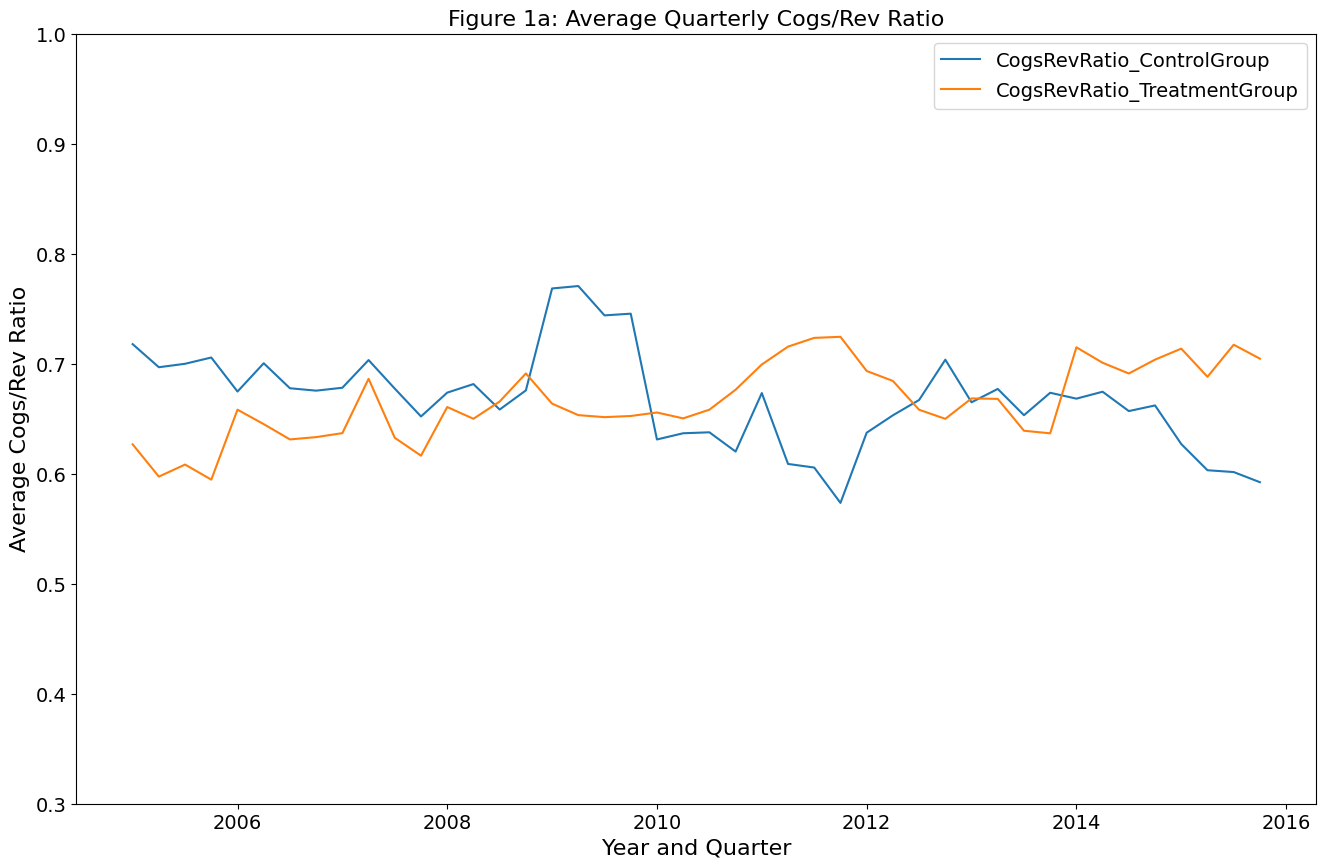

In [ ]:
plot1 = dfCaliPlot.plot(x = 'time', y = ['CogsRevRatio_ControlGroup', 'CogsRevRatio_TreatmentGroup'], kind = "line", figsize = [16, 10])
plot1.set_title("Figure 1a: Average Quarterly Cogs/Rev Ratio", fontsize=16)
plot1.set_xlabel("Year and Quarter", fontsize = 16)
plot1.set_ylabel("Average Cogs/Rev Ratio", fontsize = 16)
plot1.set_ylim(0.3, 1)
plot1.legend(fontsize=14)
plot1.tick_params(axis='both', which='both', labelsize=14)

fig = plot1.get_figure()
fig.savefig(filePath + "figure1.png")

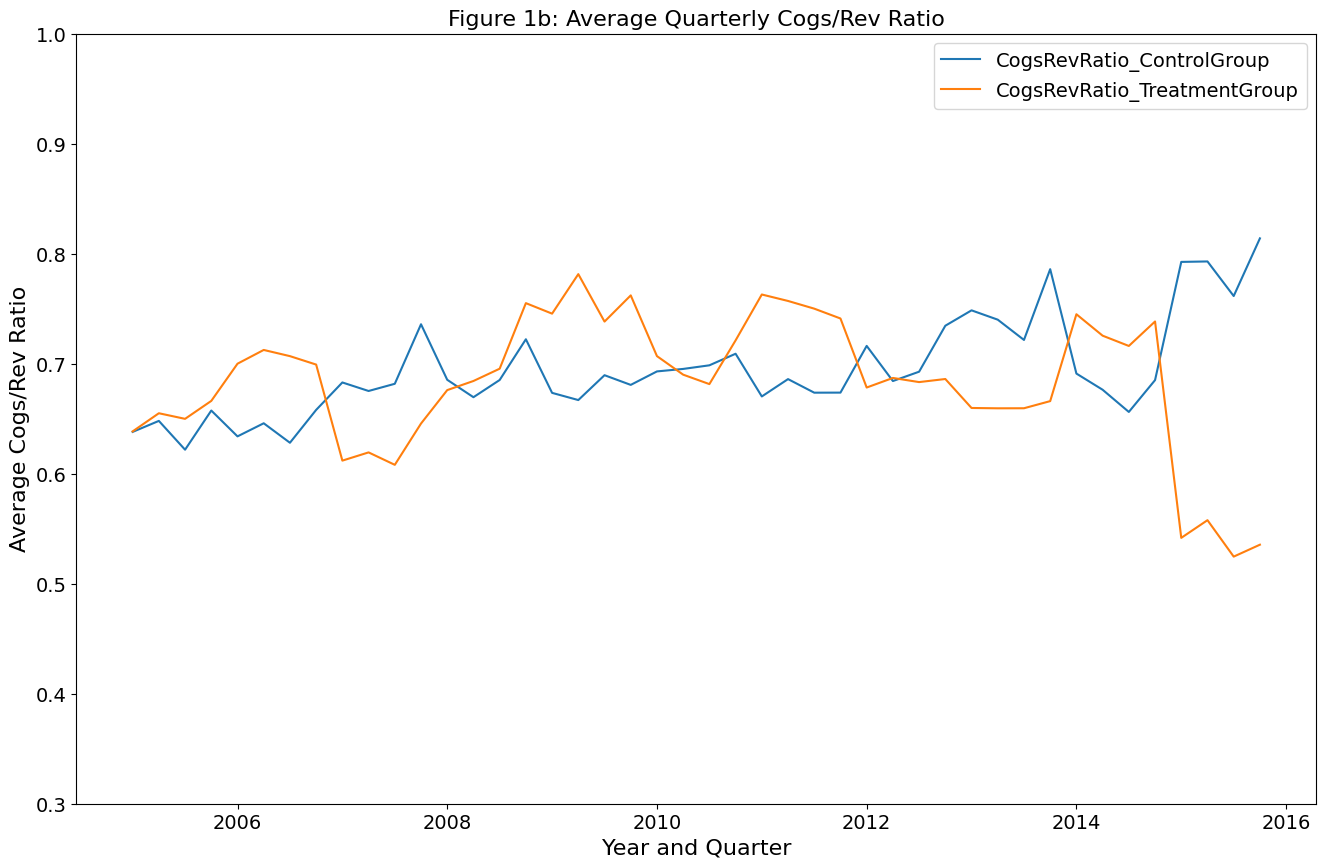

In [ ]:
plot2 = dfPlaceboPlot.plot(x = 'time', y = ['CogsRevRatio_ControlGroup', 'CogsRevRatio_TreatmentGroup'], kind = "line", figsize = [16, 10])
plot2.set_title("Figure 1b: Average Quarterly Cogs/Rev Ratio", fontsize=16)
plot2.set_xlabel("Year and Quarter", fontsize = 16)
plot2.set_ylabel("Average Cogs/Rev Ratio", fontsize = 16)
plot2.set_ylim(0.3, 1)
plot2.legend(fontsize=14)
plot2.tick_params(axis='both', which='both', labelsize=14)

fig2 = plot2.get_figure()
fig2.savefig(filePath + "figure2.png")

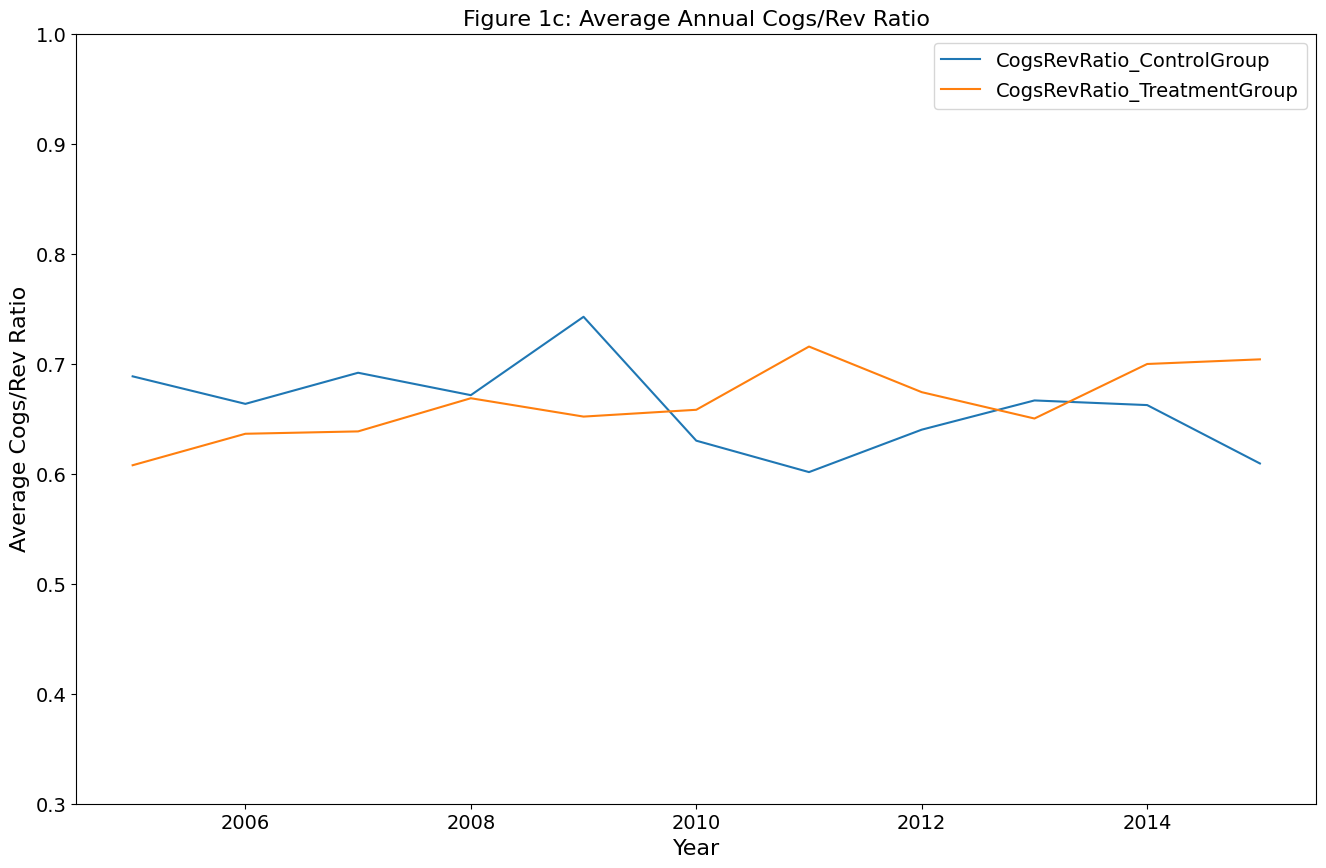

In [ ]:
plot3 = dfCaliPlotAnnual.plot(x = 'time', y = ['CogsRevRatio_ControlGroup', 'CogsRevRatio_TreatmentGroup'], kind = "line", figsize = [16, 10])
plot3.set_title("Figure 1c: Average Annual Cogs/Rev Ratio", fontsize=16)
plot3.set_xlabel("Year", fontsize = 16)
plot3.set_ylabel("Average Cogs/Rev Ratio", fontsize = 16)
plot3.set_ylim(0.3, 1)
plot3.legend(fontsize=14)
plot3.tick_params(axis='both', which='both', labelsize=14)

fig = plot3.get_figure()
fig.savefig(filePath + "figure3.png")

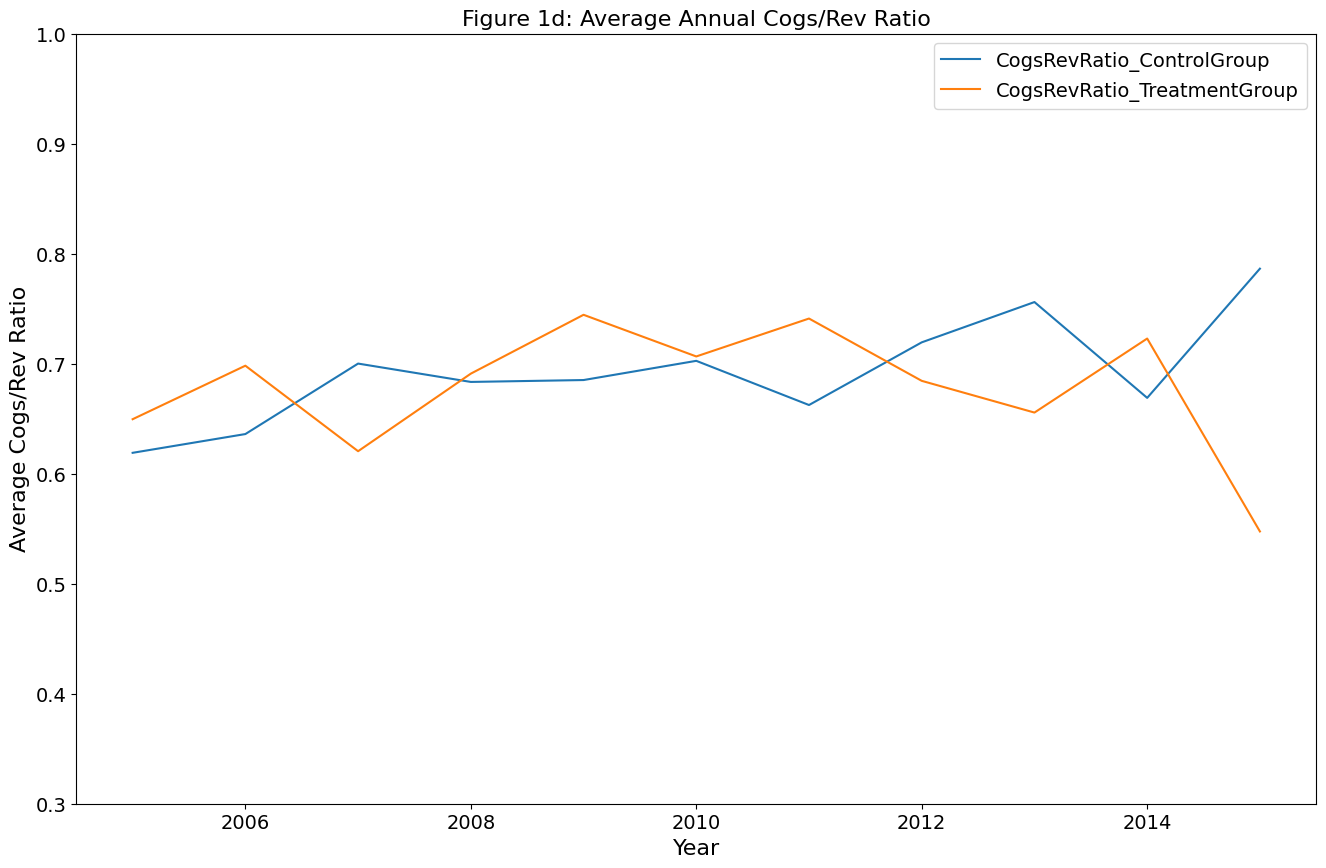

In [ ]:
plot4 = dfPlaceboPlotAnnual.plot(x = 'time', y = ['CogsRevRatio_ControlGroup', 'CogsRevRatio_TreatmentGroup'], kind = "line", figsize = [16, 10])
plot4.set_title("Figure 1d: Average Annual Cogs/Rev Ratio", fontsize=16)
plot4.set_xlabel("Year", fontsize = 16)
plot4.set_ylabel("Average Cogs/Rev Ratio", fontsize = 16)
plot4.set_ylim(0.3, 1)
plot4.legend(fontsize=14)
plot4.tick_params(axis='both', which='both', labelsize=14)

fig = plot4.get_figure()
fig.savefig(filePath + "figure4.png")

In [ ]:
unique_tic_values = set(dfACaliMerged['tic'].unique())
dfACopy = dfACopy[dfACopy['tic'].isin(unique_tic_values)]
dfACopyPlot = pd.DataFrame()

for year in range(2005, 2016):
    tempDFC = dfACopy[(dfACopy['fyear'] == year) & (dfACopy['sale'] < 100)]
    tempDFT = dfACopy[(dfACopy['fyear'] == year) & (dfACopy['sale'] >= 100)]
    CRRC = tempDFC['CogsRevRatio'].mean()
    CRRT = tempDFT['CogsRevRatio'].mean()
    time = year
    data = {'time': time, 'CogsRevRatio_ControlGroup': CRRC, 'CogsRevRatio_TreatmentGroup': CRRT}
    dfACopyPlot = dfCaliPlotAnnual.append(data, ignore_index = True)

<ipython-input-32-03fb6cb1bd2e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfACopyPlot = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-32-03fb6cb1bd2e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfACopyPlot = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-32-03fb6cb1bd2e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfACopyPlot = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-32-03fb6cb1bd2e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfACopyPlot = dfCaliPlotAnnual.append(data, ignore_index = True)
<ipython-input-32-03fb6cb1bd2e>:12: FutureWarning: The f

In [ ]:
anomaly = dfACaliMerged[(dfACaliMerged['fyear'] >= 2008) & (dfACaliMerged['fyear'] <= 2010)]
anomaly = anomaly[anomaly['treatment_x'] == 0]
anomaly_sorted = anomaly.sort_values(by='CogsRevRatio_y', ascending=False)
print(anomaly_sorted.CogsRevRatio_y.head(20))
print(anomaly_sorted.tic.head(20))

550     1.334806
551     1.279785
553     1.180923
552     1.176261
804     1.021769
742     0.971955
1339    0.961043
833     0.953169
150     0.937311
743     0.936251
738     0.930412
739     0.924350
151     0.919260
832     0.915281
737     0.910355
741     0.910042
736     0.908263
831     0.907943
1340    0.895563
1337    0.894177
Name: CogsRevRatio_y, dtype: float64
550     FCEL
551     FCEL
553     FCEL
552     FCEL
804      IPT
742     STRZ
1339    AMCO
833      GAI
150     NSYS
743     STRZ
738     STRZ
739     STRZ
151     NSYS
832      GAI
737     STRZ
741     STRZ
736     STRZ
831      GAI
1340    AMCO
1337    AMCO
Name: tic, dtype: object


In [ ]:
print(dfACaliMerged.columns)

Index(['tic', 'datadate_x', 'fyear', 'indfmt_x', 'datafmt_x', 'cogs', 'sic_x',
       'sale', 'csho', 'prcc_f', 'ceq', 'time_x', 'treatment_x',
       'CogsRevRatio_x', 'timeXtreatment_x', 'marketValue_x', 'bookToMarket_x',
       'datadate_y', 'fyearq', 'fqtr', 'indfmt_y', 'datafmt_y', 'cogsq',
       'sic_y', 'saleq', 'cshoq', 'prccq', 'ceqq', 'xsgaq', 'time_y',
       'treatment_y', 'CogsRevRatio_y', 'timeXtreatment_y', 'marketValue_y',
       'bookToMarket_y', 'log_marketValue_y'],
      dtype='object')


In [ ]:
### TESTING ASSOCIATION BETWEEN COGS AND SGA

dfACaliMerged['cogsIncrease'] = ""
dfACaliMerged['revIncrease'] = ""
for index in range(len(dfACaliMerged) - 1, 0, -1):
  if (dfACaliMerged.loc[index, 'tic'] == dfACaliMerged.loc[index - 1, 'tic']):
      if (dfACaliMerged.loc[index, 'cogsq'] - dfACaliMerged.loc[index-1, 'cogsq'] > 0):
          dfACaliMerged.loc[index, 'cogsIncrease'] = 1
      else:
          dfACaliMerged.loc[index, 'cogsIncrease'] = 0
      if (dfACaliMerged.loc[index, 'saleq'] - dfACaliMerged.loc[index-1, 'saleq'] > 0):
          dfACaliMerged.loc[index, 'revIncrease'] = 1
      else:
          dfACaliMerged.loc[index, 'revIncrease'] = 0
  else:
      dfACaliMerged.loc[index, 'cogsIncrease'] = 2
      dfACaliMerged.loc[index, 'revIncrease'] = 2

In [ ]:
dfACaliMerged['SGARevRatio'] = dfACaliMerged['xsgaq']/dfACaliMerged['saleq']
dfAPlaceboMerged['SGARevRatio'] = dfAPlaceboMerged['xsgaq']/dfAPlaceboMerged['saleq']

In [ ]:
### Finding Treatment and Control for 10Q Test
print(dfACaliMerged.tic.unique())
print(dfAPlaceboMerged.tic.unique())

['ACU' 'AMK.2' 'ANEN' 'ATRO' 'DFZ' 'NICH' 'BRID' 'CAMP' 'CVCO' 'CRWS'
 'NSYS' 'EML' 'MSN' 'SORL' 'ESCA' 'EXAR' 'BDL' 'PXFG' 'IEC' 'INVX' 'MASC'
 'MXWL' 'MCRAA' 'NSSC' 'NATH' 'PRLX.' 'RADN' 'SIF' 'SPIR.1' 'SSY' 'CUSI'
 'SPB' 'ELA' 'MAG.3' 'XETA' 'DRJ' 'FKWL' 'RBI' 'AMBA' 'MONT' 'CRFT' 'FRPT'
 'DMK.' 'UNIR' 'WING' 'AMSC' 'KOPN' 'FCEL' 'MRVC' 'ULBI' 'NEMFF' 'THRM'
 'BLDP' 'MSD.1' 'MED' 'WRLS.1' 'SGMA' 'ARTX' 'MPAA' 'BOOT.1' 'TSEM' 'BREW'
 'WSTL' 'OCC' 'CASA.1' 'BBQ' 'SNAK' 'EMKR' 'STRZ' 'CIX' 'OSPN' 'SPS.'
 'IPT' 'WPRT' 'GAI' 'JADE' 'AXTI' 'LMIA' 'SWIR' 'AUDC' 'ABLE' 'PCTI'
 'PLUG' 'CNGL.2' 'UTSI' 'PSITY' 'PXLW' 'OCNW' 'OIIM' 'ESLRQ' 'ZHNE' 'AFOP'
 'RLPHQ' 'HMDPF' 'MPX' 'TSTC' 'NEWN' 'TRLG' 'MSPD' 'REDEQ' 'CMHXF' 'PLAG'
 'GSIT' 'LDIS' 'VLTR' 'MPWR' 'AIN.U' 'RDMX.1' 'SOM.Z' 'AATI' 'TISUQ'
 'ATNY' 'OFLX' 'SIMO' 'SPWR' 'VNWTF' 'ACTS' 'ACAZF' 'CSR.' 'AIRI' 'ADNC'
 'SFLY' 'WCRS' 'NLST' 'CLNE' 'MLNX' 'DEER' 'ZAGG' 'SPI' 'RBCN' 'ENTR.1'
 'AMCO' 'OESX' 'FOHL' 'RGSEQ' 'CJJD' 'STRI' 'SAUC' 'MERU' '

### Difference in Difference in analysis for SGA

In [ ]:
reg1 = smf.ols(formula = "SGARevRatio ~ time_x + treatment_x + timeXtreatment_x", data = dfACaliMerged).fit()
print(reg1.summary())

reg2 = smf.ols(formula = "SGARevRatio ~ time_x + treatment_x + timeXtreatment_x", data = dfAPlaceboMerged).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            SGARevRatio   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.301
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0196
Time:                        22:12:14   Log-Likelihood:                 105.74
No. Observations:                1578   AIC:                            -203.5
Df Residuals:                    1574   BIC:                            -182.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2765      0.012  

In [ ]:
dfACaliForSGATest = dfACaliMerged[dfACaliMerged['cogsIncrease'] != 2]
reg1 = smf.ols(formula = "SGARevRatio ~ cogsIncrease", data = dfACaliForSGATest).fit()
print(reg1.summary())

dfACaliForSGATestControl = dfACaliForSGATest[dfACaliForSGATest['treatment_x'] == 0]
dfACaliForSGATestTreatment = dfACaliForSGATest[dfACaliForSGATest['treatment_x'] == 1]

reg2 = smf.ols(formula = "SGARevRatio ~ cogsIncrease", data = dfACaliForSGATestControl).fit()
print(reg2.summary())

reg3 = smf.ols(formula = "SGARevRatio ~ cogsIncrease", data = dfACaliForSGATestTreatment).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:            SGARevRatio   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.994
Date:                Wed, 10 Jan 2024   Prob (F-statistic):             0.0504
Time:                        22:12:14   Log-Likelihood:                 101.84
No. Observations:                1425   AIC:                            -197.7
Df Residuals:                    1422   BIC:                            -181.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3192      0.00

In [ ]:
dfAPlaceboMerged['cogsIncrease'] = ""
dfAPlaceboMerged['revIncrease'] = ""
for index in range(len(dfAPlaceboMerged) - 1, 0, -1):
  if (dfAPlaceboMerged.loc[index, 'tic'] == dfAPlaceboMerged.loc[index - 1, 'tic']):
      if (dfAPlaceboMerged.loc[index, 'cogsq'] - dfAPlaceboMerged.loc[index-1, 'cogsq'] > 0):
          dfAPlaceboMerged.loc[index, 'cogsIncrease'] = 1
      else:
          dfAPlaceboMerged.loc[index, 'cogsIncrease'] = 0
      if (dfAPlaceboMerged.loc[index, 'saleq'] - dfAPlaceboMerged.loc[index-1, 'saleq'] > 0):
          dfAPlaceboMerged.loc[index, 'revIncrease'] = 1
      else:
          dfAPlaceboMerged.loc[index, 'revIncrease'] = 0
  else:
      dfAPlaceboMerged.loc[index, 'cogsIncrease'] = 2
      dfAPlaceboMerged.loc[index, 'revIncrease'] = 2


dfAPlaceboForSGATest = dfAPlaceboMerged[dfAPlaceboMerged['cogsIncrease'] != 2]
reg1 = smf.ols(formula = "xsgaq ~ cogsIncrease", data = dfAPlaceboForSGATest).fit()
print(reg1.summary())

dfAPlaceboForSGATestControl = dfAPlaceboForSGATest[dfAPlaceboForSGATest['treatment_x'] == 0]
dfAPlaceboForSGATestTreatment = dfAPlaceboForSGATest[dfAPlaceboForSGATest['treatment_x'] == 1]

reg2 = smf.ols(formula = "xsgaq ~ cogsIncrease", data = dfAPlaceboForSGATestControl).fit()
print(reg2.summary())

reg3 = smf.ols(formula = "xsgaq ~ cogsIncrease", data = dfAPlaceboForSGATestTreatment).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                  xsgaq   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.022
Date:                Wed, 10 Jan 2024   Prob (F-statistic):            0.00668
Time:                        22:12:15   Log-Likelihood:                -5536.8
No. Observations:                1867   AIC:                         1.108e+04
Df Residuals:                    1864   BIC:                         1.110e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.2917      0.16

In [ ]:
file = "/content/gdrive/MyDrive/Research Paper Cohort 2/Q10Sentiment.csv"
Q10 = pd.read_csv(file)
print(Q10.head(10))

file = "/content/gdrive/MyDrive/Research Paper Cohort 2/K10Sentiment.csv"
K10 = pd.read_csv(file)
print(K10.head(10))

  Ticker                       Date  Year  Month  \
0   NATH  2015-11-05 11:06:36+00:00  2015     11   
1   NATH  2015-08-07 10:07:09+00:00  2015      8   
2   NATH  2015-02-06 11:07:50+00:00  2015      2   
3   NATH  2014-11-07 11:06:57+00:00  2014     11   
4   NATH  2014-08-08 10:06:23+00:00  2014      8   
5   NATH  2014-02-07 11:06:11+00:00  2014      2   
6   NATH  2013-11-08 11:47:42+00:00  2013     11   
7   NATH  2013-08-09 10:08:53+00:00  2013      8   
8   NATH  2013-02-01 11:00:59+00:00  2013      2   
9   NATH  2012-11-02 10:04:29+00:00  2012     11   

                                                 URL  \
0  https://www.sec.gov/Archives/edgar/data/69733/...   
1  https://www.sec.gov/Archives/edgar/data/69733/...   
2  https://www.sec.gov/Archives/edgar/data/69733/...   
3  https://www.sec.gov/Archives/edgar/data/69733/...   
4  https://www.sec.gov/Archives/edgar/data/69733/...   
5  https://www.sec.gov/Archives/edgar/data/69733/...   
6  https://www.sec.gov/Archives/edg

In [ ]:
Q10['qtr'] = pd.cut(Q10['Month'], bins=[0, 3, 6, 9, 12], labels=[1, 2, 3, 4])
K10['qtr'] = pd.cut(Q10['Month'], bins=[0, 3, 6, 9, 12], labels=[1, 2, 3, 4])

In [ ]:
print(Q10.columns)

Index(['Ticker', 'Date', 'Year', 'Month', 'URL', 'MDAsection_text',
       'RiskFactorssection_text', 'Litigationsection_text', 'MDA_sentiment',
       'RiskFactors_sentiment', 'Litigation_sentiment', 'qtr'],
      dtype='object')


In [ ]:
print(dfACaliMerged.columns)

Index(['tic', 'datadate_x', 'fyear', 'indfmt_x', 'datafmt_x', 'cogs', 'sic_x',
       'sale', 'csho', 'prcc_f', 'ceq', 'time_x', 'treatment_x',
       'CogsRevRatio_x', 'timeXtreatment_x', 'marketValue_x', 'bookToMarket_x',
       'datadate_y', 'fyearq', 'fqtr', 'indfmt_y', 'datafmt_y', 'cogsq',
       'sic_y', 'saleq', 'cshoq', 'prccq', 'ceqq', 'xsgaq', 'time_y',
       'treatment_y', 'CogsRevRatio_y', 'timeXtreatment_y', 'marketValue_y',
       'bookToMarket_y', 'log_marketValue_y', 'cogsIncrease', 'revIncrease',
       'SGARevRatio'],
      dtype='object')


In [ ]:
FinalQ = pd.merge(dfACaliMerged, Q10,
                     left_on=['fqtr', 'fyear', 'tic'],
                     right_on=['qtr', 'Year', 'Ticker'],
                     how='left')  # Use 'left' to keep all columns from dfACaliMerged

FinalQ = pd.merge(dfACaliMerged, Q10,
                     left_on=['fqtr', 'fyear', 'tic'],
                     right_on=['qtr', 'Year', 'Ticker'],
                     how='left')  # Use 'left' to keep all columns from dfACaliMerged


In [ ]:
FinalQControl = FinalQ[FinalQ['treatment_x'] == 0]
FinalQTreatment = FinalQ[FinalQ['treatment_x'] == 1]

In [ ]:
print(FinalQControl.MDA_sentiment.mean())
print(FinalQTreatment.MDA_sentiment.mean())

-0.7126487177228601
-0.6762982221460951
